#Lab.03 / IBM3202 – Phylogenetic Analysis using biopython and RAxML

## Theoretical Aspects 

Phylogenetic analysis lies at the core of genomics and bioinformatics and seeks to establish the evolutionary relationships between different homologous DNA or protein sequences and their ancestral sequences (common ancestors) from which they emerge. A typical result from a phylogenetic analysis is a **phylogenetic tree**, such as the following:

<figure>
<center>
<img src='https://raw.githubusercontent.com/pb3lab/ibm3202/master/images/phylo_01.png' width=500/>
<figcaption>FIGURE 1. A phylogenetic tree visually represents a hypothesis of how a group of sequences
are related. This figure explores how the way a tree is drawn conveys information. This tree shows how the seven sequences at the tips of the branches, called taxa, are related. Each horizontal branch represents an evolutionary
lineage. The length of the branch is arbitrary
unless the diagram specifies that branch lengths
represent information such as time or amount of
genetic change. Each branch point represents the common ancestor of the evolutionary lineages diverging from it. One of these branch points represents the common ancestor of all the sequences shown in this tree.
<br>Urry LA et al (2020). Campbell Biology. <i>Pearson Education, 12th Ed</i></figcaption></center>
</figure>

In this representation, the tips of the tree (or the leaves) correspond to different, currently existing sequences of genes or proteins (usually called the **taxa**), thus they represent real data. The **nodes** or branch points connecting two sequences are the points of divergence in sequence evolution, namely **common ancestors** of extant taxa. The connection of two or more sequences with a hypothetical, extinct ancestral sequence allows grouping actual sequences into **clades**. On the other hand, the branch lengths represent the evolutionary changes between an ancestor and its descendant. Please notice that we are saying **'sequences'** and not **'species'**, as such statement requires the assumption of genetic isolation (i.e. all sequences in a given species show the same evolutionary drifts, but we learn from lectures that we can have horizontal gene transfer, right?).

Many things can be said about this tree. First, a **phylogenetic tree** is based on a multiple sequence alignment and thus it is **as good as the alignment is**. See for example the polytomy in the ancestral node connecting taxa D, E and F; the sequence information between these sequences did not allow discerning how these sequences evolved from a common ancestor (i.e. imagine that there were two mutations and the phylogenetic analysis does not know which one comes first or second).

Second, taxon G is defined as a **basal taxon**, a lineage that diverges from all other members of its group early in the history of the group.

Lastly, the phylogenetic tree is **rooted** through an **outgroup**, i.e. a sequence (or a group or sequences) that is more distantly related to the ingroup sequences than the ingroup sequences are to each other; a distant homolog. As an outgroup sequence is not easy to define for all phylogenetic inferences, a vast number of phylogenetic trees in the literature are **unrooted** (i.e. there is no outgroup).

A phylogenetic tree is an estimation of the possible routes of evolution from ancestral lineages to present-day sequences that depends on many variables. We will smoothly go through all the steps of this inference, from sequence alignment to the “resurrection” of the most probable ancestral sequence.

## Overview

In this tutorial we will work with the family of forkhead box (Fox) transcription factors, a protein family that we currently study [Medina E et al (2016) *Biophys J 110 (11), 2349-2360*; Medina E et (2020) *J Mol Biol 432(19), 5411-5429*] in collaboration with the [Biochemistry and Molecular Biology Lab at U de Chile](https://sites.google.com/view/labbq) .

These proteins are master controllers of gene expression in several eukaryotes since early *Bilateria*, and recently it has been determined that they also participate in chromosome remodeling since their structure is similar to the structure of histones. In humans, there are 19 different Fox subfamilies (from A to S), with almost all of them corresponding to monomeric proteins, except for FoxP. The members of the FoxP subfamily are known to form dimers to allow forming long-distance chromosome interactions due to a key Pro-to-Ala mutation in their sequence (see below).

<figure>
<center>
<img src='https://raw.githubusercontent.com/pb3lab/ibm3202/master/images/phylo_02.png'/>
<figcaption>FIGURE 2. Sequence determinants of the structural acrobatics of the DNA-binding domain of human FoxP transcription factors. The left panel shows how FoxP proteins oligomerize by exchanging identical secondary structure elements between adjacent subunits, a mechanism known as domain swapping. An experimentally validated key Ala residue that enables domain swapping is indicated, which has been demonstrated to be conserved in all human FoxP proteins and replaced by Pro in all monomeric Fox members, as shown in the multiple sequence alignment on the right.
<br> Medina E et al (2016) <i>Biophys J 110 (11), 2349-2360</i>; Stroud JC et al (2008) <i>Structure 14(1), 159-66</i></figcaption></center>
</figure>

Today, we will infer where did the evolutionary novelty of forming dimers emerged during the
evolution of Fox proteins using **RAxML** (Randomized Axelerated Maximum Likelihood), a popular program for phylogenetic analyses of large datasets under maximum likelihood.

#Part 0. Downloading and Installing the required software

Before we start, you must first **remember to start the hosted runtime in Google Colab**.

Then, we must install several pieces of software to perform this tutorial. Namely:
- **biopython** for searching, retrieving, parsing and storing DNA and protein sequences.
- **MAFFT**, a multiple sequence alignment program for unix-like operating systems that offers a range of multiple alignment methods.
- **miniconda**, a free minimal installer of **conda** for software package and environment management.
- **ModelTest-ng**, a tool for selecting the best-fit model of evolution for DNA and protein alignments.
- **RAxML-ng**, a phylogenetic tree inference tool which uses maximum-likelihood (ML) optimality criterion.

After several tests, the following installation instructions are the best way of setting up **Google Colab** for this laboratory session.

1. We will first install biopython as follows:

In [ ]:
#Installing biopython using pip
!pip install biopython

     |████████████████████████████████| 2.3 MB 5.4 MB/s 


In [ ]:
#Importing biopython and os for safety
import os
import sys
import Bio

2. Then, we will install MAFFT:

In [ ]:
#Installing MAFFT using apt-get in quiet mode
!apt-get -qq install -y mafft

In [ ]:
#Checking that MAFFT was succesfully installed
!mafft --help


------------------------------------------------------------------------------
  MAFFT v7.310 (2017/Mar/17)
  http://mafft.cbrc.jp/alignment/software/
  MBE 30:772-780 (2013), NAR 30:3059-3066 (2002)
------------------------------------------------------------------------------
High speed:
  % mafft in > out
  % mafft --retree 1 in > out (fast)

High accuracy (for <~200 sequences x <~2,000 aa/nt):
  % mafft --maxiterate 1000 --localpair  in > out (% linsi in > out is also ok)
  % mafft --maxiterate 1000 --genafpair  in > out (% einsi in > out)
  % mafft --maxiterate 1000 --globalpair in > out (% ginsi in > out)

If unsure which option to use:
  % mafft --auto in > out

--op # :         Gap opening penalty, default: 1.53
--ep # :         Offset (works like gap extension penalty), default: 0.0
--maxiterate # : Maximum number of iterative refinement, default: 0
--clustalout :   Output: clustal format, default: fasta
--reorder :      Outorder: aligned, default: input order
--quiet :      

3. Finally, we will install conda to be able to install RAxML-NG and ModelTest-NG as follows:

In [ ]:
#Install conda using the new conda-colab library
!pip install -q condacolab
import condacolab
condacolab.install_miniconda()

#Install RAxML-NG and ModelTest-NG from
#the bioconda repository
!conda install -c bioconda raxml-ng modeltest-ng --yes

#MAFFT could be also installed with conda
#using !conda install -c bioconda -y mafft
#We opted for apt-get instead

#Part I - Retrieve Fox protein sequences using BLAST

Here, we will present two different options to retrieve Fox protein sequences.
1. Retrieving protein sequences using the web version of BLAST
2. Retrieving protein sequences using BLAST over biopython

##Part I.A - Retrieve Fox protein sequences using the web version of BLAST

1. We will begin by opening a new window with [BLAST](https://blast.ncbi.nlm.nih.gov/Blast.cgi). Here, select **blastp** for protein sequences. Then, in the *“Enter accession number(s), gi(s) or FASTA sequence(s)”* box, write **2KIU_A**.

  Also, we will indicate BLAST to only search for human sequences (**Search Set** option **Organism: humans**) from the Protein Data Bank (**Search Set** option **Database: Protein Data Bank (pdb)**), as shown below.

**QUESTION:** There are different types of BLAST. What does each one of them do?

<figure>
<center>
<img src='https://raw.githubusercontent.com/pb3lab/ibm3202/master/images/phylo_03.png'/>
</center>
</figure>

2. The results from this BLAST are shown below. It is important to note that the first hit is actually our query sequence: **2KIU**. Also, all other sequences have similar 4-character codes.

  If you remember from our previous tutorial on protein structure visualization using **py3Dmol**, these 4-character codes correspond to **Protein Data Bank (PDB)** accession IDs. These structures are always accompanied by a FASTA sequence of the crystallized protein.

  We **strongly recommend** you to access the [PDB website](https://www.rcsb.org/) and analyze the information that is deposited for each one of these structures.

<figure>
<center>
<img src='https://raw.githubusercontent.com/pb3lab/ibm3202/master/images/phylo_04.png'/>
</center>
</figure>

3. We will download some of these sequences for our work. To collect these sequences for future analysis (e.g. multiple sequence alignments) we need to select the sequences that we would like to download, click on **Download** and select the **FASTA (complete sequences)** option. Then, you can either upload this file or copy these sequences onto a new file in Google Colab.


**QUESTION:** Which parameters from BLAST would be important to decide which sequences to collect and which sequences to discard? Are we able to include more sequences?

**💡 HINT:** Please note that we are using the PDB protein database only for the purposes of this tutorial, as it has a limited number of protein sequences (due to the limited number of structures). However, you might find the use of another database more suitable for your work with your own protein or DNA sequences, as they contain a higher number of sequences, hence a higher sequence variability/redundancy.

## Part I.B - Retrieve Fox protein sequences using biopython

Biopython is an excellent companion for working with DNA and protein sequences and also with structures. Here, we will show how to use it for retrieving Fox protein sequences.

1. First, we will start by using _Entrez_ to retrieve the sequence of accession code **2KIU_A** in FASTA format and _SeqIO_ to be able to read, parse and/or write this sequence. Besides downloading our sequence, we will also store the sequence into a string (here, termed as _aaseq_) for its subsequent use in this tutorial.

In [ ]:
from Bio import SeqIO, Entrez
#Setting up your email to be able to use Entrez
Entrez.email = 'your.email@uc.cl'
#Here, we set up a temporary handle with our downloaded sequence in fasta format
temp = Entrez.efetch(db="protein",rettype="fasta",id="2KIU_A")
#Creating a fasta file to write our downloaded sequence
aaseq_out = open("2KIU_A.fasta",'w')
#Reading the sequence information as a string in fasta format
aaseq = SeqIO.read(temp, format="fasta")
#Writing the sequence record in fasta format
SeqIO.write(aaseq,aaseq_out,"fasta")
#Closing both the temp handle and the FASTA file
temp.close()
aaseq_out.close()

2. What is great about _SeqIO_ is that you can use it to manipulate your sequence (e.g. sorting, changing formats, etc) and also to print information about your sequence, such as its description, sequence and accession ID.

  You can try these commands below by first writing **"aaseq."** and then selecting one of the autocomplete options suggested by Google Colab. With this information, try to obtain the information requested below.

In [ ]:
#Printing the number of amino acids as an example
print("Sequence length (aa):")
print(len(aaseq))

Sequence length (aa):
87


In [ ]:
#Printing the description of the sequence
print("The description of the sequence is:")
#INSERT YOUR OWN COMMAND HERE
print()

#Printing the accession ID of the sequence
print("The ID of the sequence is:")
#INSERT YOUR OWN COMMAND BELOW
print()

#Printing the sequence
print("The sequence is:")
#INSERT YOUR OWN COMMAND BELOW
print()


The description of the sequence is:

The ID of the sequence is:

The sequence is:



**💡 HINT:** If you only have a protein/nucleic sequence instead of an accession ID, you can store the sequence in a string using the _**Seq**_ function as shown below.

In [ ]:
#In case you do not have an accession ID, but just a sequence
from Bio.Seq import Seq
my_seq = Seq("AEVRPPFTYASLIRQAILESPEKQLTLNEIYNWFTRMFPYFRRNAATWKNAVRHNLSLHKYFVRVENVKGAVWTVDEVEFQKRRPQK")

3. Once we have already stored the information of our query sequence in a string, we can use it to perform a BLAST search inside Google Colab via biopython through _NCBIWWW_.

  The code cell bellow specifies the blast program **blastp**, the database **pdb** and the query sequence. This process should not take longer than 2 min.

  **💡 HINT:** Please note that we are using the PDB protein database only for the purposes of this tutorial, as it has a limited number of protein sequences (due to the limited number of structures). However, you might find the use of another database more suitable for your work with your own protein or DNA sequences, as they contain a higher number of sequences, hence a higher sequence variability/redundancy. For the purposes of this tutorial, we are also specifying to retrieve sequences only belonging to humans. 

In [ ]:
#Using biopython to perform a blast search
%%time
from Bio.Blast import NCBIWWW
#NCBIWWW.qblast(program, database, sequence)
result_handle = NCBIWWW.qblast("blastp", "pdb", aaseq.seq, entrez_query='human[organism]')

CPU times: user 311 ms, sys: 44.7 ms, total: 355 ms
Wall time: 1min 1s


4. In order to parse this data, we need to store it in a handle for post-processing using _NCBIXML_, as shown below:

In [ ]:
#Read the results in XML format for parsing BLAST records
from Bio.Blast import NCBIXML
blast_record = NCBIXML.read(result_handle)
#This is required to reset the searches and start over again
result_handle.close()

5. _NCBIXML_ enables data manipulation similarly to what we saw before for _SeqIO_. In the following code cell, try to obtain the BLAST **hit id**, sequence **length** and **expect**-value or e-value for each high-scoring pair (HSP), using again the autocomplete function of Google Colab.

In [ ]:
#Testing the functions of NCBIXML parsing
for alignment in blast_record.alignments:
  for hsp in alignment.hsps:
    #Example with the accession code
    print("Hit ID:")
    print(alignment.hit_id)
    #Now try it yourself for printing the sequence lenght
    
    print("Hit sequence length:")
    #INSERT YOUR OWN COMMAND BELOW
    print()
    
    #Now print the e-value for each hit
    print("E-value:")
    #INSERT YOUR OWN COMMAND BELOW
    print()

Hit ID:
pdb|2KIU|A
Hit sequence length:

E-value:

Hit ID:
pdb|6XAT|A
Hit sequence length:

E-value:

Hit ID:
pdb|2A07|F
Hit sequence length:

E-value:

Hit ID:
pdb|3QRF|F
Hit sequence length:

E-value:

Hit ID:
pdb|2C6Y|A
Hit sequence length:

E-value:

Hit ID:
pdb|1JXS|A
Hit sequence length:

E-value:

Hit ID:
pdb|7CBY|C
Hit sequence length:

E-value:

Hit ID:
pdb|1D5V|A
Hit sequence length:

E-value:

Hit ID:
pdb|6O3T|A
Hit sequence length:

E-value:

Hit ID:
pdb|6NCE|A
Hit sequence length:

E-value:

Hit ID:
pdb|6AKO|C
Hit sequence length:

E-value:

Hit ID:
pdb|5X07|C
Hit sequence length:

E-value:

Hit ID:
pdb|1VTN|C
Hit sequence length:

E-value:

Hit ID:
pdb|2UZK|A
Hit sequence length:

E-value:

Hit ID:
pdb|2K86|A
Hit sequence length:

E-value:

Hit ID:
pdb|3L2C|A
Hit sequence length:

E-value:

Hit ID:
pdb|1E17|A
Hit sequence length:

E-value:

Hit ID:
pdb|3CO6|C
Hit sequence length:

E-value:

Hit ID:
pdb|5A5U|B
Hit sequence length:

E-value:

Hit ID:
pdb|5DUI|A
Hit sequence

6. We can use all these functions to print a BLAST-like briefing of the results, and to even filter the results according to parameters such as the sequence identity, coverage and/or e-value. **Carefully examine the commands below to achieve this and the resulting output.**

In [ ]:
#Here, we show how we can set a sequence identity cut-off
#Many other cut-offs can be employed!
PIDcut=1.00
#Printing all BLAST parameters similarly to the website
for alignment in blast_record.alignments:
  for hsp in alignment.hsps:
#Here, we add a condition to only print hits equal or less than a PID cutoff
    if(hsp.identities/hsp.align_length) <= PIDcut:
      print("Accession code:", alignment.hit_id)
      print("Sequence length:", alignment.length)
      print("Alignment length:", hsp.align_length)
      print("E-value:", hsp.expect)
#The following command calculates the sequence identity relative to
#the length of the alignment
      print("Sequence Identity [%]:", "{:.2f}".format(100*hsp.identities/hsp.align_length))
#The following command calculates the sequence coverage relative to
#the lenght of the sequence
      print("Sequence Coverage [%]:", "{:.2f}".format(100*sum(c.isalpha() for c in hsp.query)/len(aaseq)))
      print()
#Here, we print the first 60 characters of the query and hit and their matches
      print("query:", hsp.query[0:60] + "...")
      print("      ", hsp.match[0:60] + "...")
      print("sbjct:", hsp.sbjct[0:60] + "...")
      print()


Accession code: pdb|2KIU|A
Sequence length: 87
Alignment length: 87
E-value: 1.74379e-61
Sequence Identity [%]: 100.00
Sequence Coverage [%]: 100.00

query: AEVRPPFTYASLIRQAILESPEKQLTLNEIYNWFTRMFPYFRRNAATWKNAVRHNLSLHK...
       AEVRPPFTYASLIRQAILESPEKQLTLNEIYNWFTRMFPYFRRNAATWKNAVRHNLSLHK...
sbjct: AEVRPPFTYASLIRQAILESPEKQLTLNEIYNWFTRMFPYFRRNAATWKNAVRHNLSLHK...

Accession code: pdb|6XAT|A
Sequence length: 110
Alignment length: 87
E-value: 9.29566e-55
Sequence Identity [%]: 88.51
Sequence Coverage [%]: 100.00

query: AEVRPPFTYASLIRQAILESPEKQLTLNEIYNWFTRMFPYFRRNAATWKNAVRHNLSLHK...
       A+VRPPFTYASLIRQAILE+P++QLTLNEIYNWFTRMF YFRRN ATWKNAVRHNLSLHK...
sbjct: ADVRPPFTYASLIRQAILETPDRQLTLNEIYNWFTRMFAYFRRNTATWKNAVRHNLSLHK...

Accession code: pdb|2A07|F
Sequence length: 93
Alignment length: 85
E-value: 1.16538e-52
Sequence Identity [%]: 87.06
Sequence Coverage [%]: 97.70

query: VRPPFTYASLIRQAILESPEKQLTLNEIYNWFTRMFPYFRRNAATWKNAVRHNLSLHKYF...
       VRPPFTYA+LIRQAI+ES ++QLTLNEIY+WFTR F YFRRNAATW

**QUESTION:** Which parameters from BLAST would be important to decide which sequences to collect and which sequences to discard? Are we able to include more sequences?

**📚 HOMEWORK:** Copy the code cell above and edit it to add other filters, such as a minimum E-value and sequence coverage.

7. After the BLAST search and filtering, we would like to retrieve all sequences that match our selection criteria. Here, we opted to download the top 20 sequences, but you can use filters such as minimum sequence coverage, minimum e-value and maximum PID to limit your output sequences.

In [ ]:
#Setting up your email to be able to use Entrez
Entrez.email = 'your.email@uc.cl'

#Generate a loop to write all sequences into an output file
with open("sequences.fasta", "a") as allhits_out:
#Check how we are indicating to use the top 20 hits
  for alignment in blast_record.alignments[:20]:
    for hsp in alignment.hsps:
    #Here, we add a condition to print only sequences below a PID cutoff
      if(hsp.identities/len(hsp.match)) <= PIDcut:
        print("Fetching protein sequence:", alignment.hit_id)
        fetch = Entrez.efetch(db="protein", id=alignment.hit_id, rettype="fasta")
        #Reading the sequence stored in the temporary string in fasta format
        allhits_seqs = SeqIO.read(fetch, format="fasta")
        #Writing the sequence and its ID in fasta format
        SeqIO.write(allhits_seqs,allhits_out,"fasta")
        fetch.close()
#Closing the efetch and file
allhits_out.close()

Fetching protein sequence: pdb|2KIU|A
Fetching protein sequence: pdb|6XAT|A
Fetching protein sequence: pdb|2A07|F
Fetching protein sequence: pdb|3QRF|F
Fetching protein sequence: pdb|2C6Y|A
Fetching protein sequence: pdb|1JXS|A
Fetching protein sequence: pdb|7CBY|C
Fetching protein sequence: pdb|1D5V|A
Fetching protein sequence: pdb|6O3T|A
Fetching protein sequence: pdb|6NCE|A
Fetching protein sequence: pdb|6AKO|C
Fetching protein sequence: pdb|5X07|C
Fetching protein sequence: pdb|1VTN|C
Fetching protein sequence: pdb|2UZK|A
Fetching protein sequence: pdb|2K86|A
Fetching protein sequence: pdb|3L2C|A
Fetching protein sequence: pdb|1E17|A
Fetching protein sequence: pdb|3CO6|C
Fetching protein sequence: pdb|5A5U|B
Fetching protein sequence: pdb|5DUI|A


#Part II - Obtain and edit a Multiple Sequence Alignment (MSA) using MAFFT and biopython

Once BLAST is resolved, we can proceeed with the **Multiple Sequence Alignment (MSA)**. In this case, we will first employ **MAFFT** to align all retrieved sequences.

1. To perform a MSA alignment using MAFFT, we can again use the biopython _Bio.Align.Applications_ wrapper as shown in the code cell below.

In [ ]:
from Bio.Align.Applications import MafftCommandline
mafft_cline=MafftCommandline(input="sequences.fasta")
print(mafft_cline)
stdout, stderr = mafft_cline()
with open("aligned.fasta", "w") as handle:
  handle.write(stdout)
from Bio import AlignIO
align = AlignIO.read("aligned.fasta", "fasta")

mafft sequences.fasta


2. The result from this algorithm, which is an extension of the **Pairwise Alignment Algorithms** we discussed during Lectures, can be seen in an online MSA viewer such as [Alignment Viewer 2.0](https://fast.alignmentviewer.org/). Nevertheless, some recent developments using **Panel** widgets and the **Bokeh** interactive plotting library for Python for use in web browsers and dashboards. Here, we will be using one of such developments.

In [ ]:
#@title Protein MSA Viewer in Google Colab
#The following code is modified from the wonderful viewer developed by Damien Farrell
#https://dmnfarrell.github.io/bioinformatics/bokeh-sequence-aligner

#Importing all modules first
import os, io, random
import string
import numpy as np

from Bio.Seq import Seq
from Bio.Align import MultipleSeqAlignment
from Bio import AlignIO, SeqIO

import panel as pn
import panel.widgets as pnw
pn.extension()

from bokeh.plotting import figure
from bokeh.models import ColumnDataSource, Plot, Grid, Range1d
from bokeh.models.glyphs import Text, Rect
from bokeh.layouts import gridplot

#Setting up the amino color code according to Zappo color scheme
def get_colors(seqs):
    #make colors for bases in sequence
    text = [i for s in list(seqs) for i in s]
    #Use Zappo color scheme
    clrs =  {'K':'red',
             'R':'red',
             'H':'red',             
             'D':'green',
             'E':'green',
             'Q':'blue',
             'N':'blue',
             'S':'blue',
             'T':'blue',
             'A':'blue',
             'I':'blue',
             'L':'blue',
             'M':'blue',
             'V':'blue',
             'F':'orange',
             'Y':'orange',
             'W':'orange',
             'C':'blue',
             'P':'yellow',
             'G':'orange',
             '-':'white'}
    colors = [clrs[i] for i in text]
    return colors

#Setting up the MSA viewer
def view_alignment(aln, fontsize="9pt", plot_width=800):
    """Bokeh sequence alignment view"""

    #make sequence and id lists from the aln object
    seqs = [rec.seq for rec in (aln)]
    ids = [rec.id for rec in aln]    
    text = [i for s in list(seqs) for i in s]
    colors = get_colors(seqs)    
    N = len(seqs[0])
    S = len(seqs)    
    width = .4

    x = np.arange(1,N+1)
    y = np.arange(0,S,1)
    #creates a 2D grid of coords from the 1D arrays
    xx, yy = np.meshgrid(x, y)
    #flattens the arrays
    gx = xx.ravel()
    gy = yy.flatten()
    #use recty for rect coords with an offset
    recty = gy+.5
    h= 1/S
    #now we can create the ColumnDataSource with all the arrays
    source = ColumnDataSource(dict(x=gx, y=gy, recty=recty, text=text, colors=colors))
    plot_height = len(seqs)*15+50
    x_range = Range1d(0,N+1, bounds='auto')
    if N>100:
        viewlen=100
    else:
        viewlen=N
    #view_range is for the close up view
    view_range = (0,viewlen)
    tools="xpan, xwheel_zoom, reset, save"

    #entire sequence view (no text, with zoom)
    p = figure(title=None, plot_width= plot_width, plot_height=50,
               x_range=x_range, y_range=(0,S), tools=tools,
               min_border=0, toolbar_location='below')
    rects = Rect(x="x", y="recty",  width=1, height=1, fill_color="colors",
                 line_color=None, fill_alpha=0.6)
    p.add_glyph(source, rects)
    p.yaxis.visible = False
    p.grid.visible = False  

    #sequence text view with ability to scroll along x axis
    p1 = figure(title=None, plot_width=plot_width, plot_height=plot_height,
                x_range=view_range, y_range=ids, tools="xpan,reset",
                min_border=0, toolbar_location='below')#, lod_factor=1)          
    glyph = Text(x="x", y="y", text="text", text_align='center',text_color="black",
                text_font="monospace",text_font_size=fontsize)
    rects = Rect(x="x", y="recty",  width=1, height=1, fill_color="colors",
                line_color=None, fill_alpha=0.4)
    p1.add_glyph(source, glyph)
    p1.add_glyph(source, rects)

    p1.grid.visible = False
    p1.xaxis.major_label_text_font_style = "bold"
    p1.yaxis.minor_tick_line_width = 0
    p1.yaxis.major_tick_line_width = 0

    p = gridplot([[p],[p1]], toolbar_location='below')
    return p

#Loading the viewer by indicating the MSA file and format to read
#@markdown Name of the MSA file (including the filetype)
MSAfile = 'aligned.fasta' #@param {type:"string"}
MSAformat = 'fasta' #@param {type:"string"}
aln = AlignIO.read(MSAfile,MSAformat)
p = view_alignment(aln, plot_width=900)
pn.pane.Bokeh(p)

Bokeh(Column)

3. As you can see, the sequences are aligned, as many residues that are conserved between different sequences occupy the same columns within the alignment. However, **we can also see
some sequences that are longer on the ends of the protein**. These ends will contribute nothing to the alignment, as there is nothing to compare them to. Therefore, we will trim the sequences on both N-and C-ends by selecting the regions we want to eliminate.

  Ideally, you would manually correct the alignment and trim the ends of the sequences, and **we encourage you to do it**. Due to time restrictions, we include a script below that trims the N- and C-ends of the alignment based on finding the first and lasts columns of the MSA without any gaps.


In [28]:
import sys
from Bio import AlignIO
aln = AlignIO.read("aligned.fasta", "fasta")

for fcol in range(aln.get_alignment_length()):
  if not "-" in aln[:, fcol]:
    position1 = fcol
    print("First full column is {}".format(fcol))
    break
for lcol in reversed(range(aln.get_alignment_length())):
  if not "-" in aln[:, lcol]:
    position2 = lcol+1
    print("Last full column is {}".format(lcol))
    break

print("New alignment:")
print(aln[:, position1:position2])

with open("aligned_trimmed.fasta", "w") as handle:
  count = (SeqIO.write(aln[:, position1:position2], handle, "fasta"))

trim = AlignIO.read("aligned_trimmed.fasta", "fasta")

First full column is 169
Last full column is 261
New alignment:
Alignment with 20 rows and 93 columns
RPPFTYASLIRQAILESPEKQLTLNEIYNWFTRMFPYFR-----...--E pdb|2KIU|A
RPPFTYASLIRQAILETPDRQLTLNEIYNWFTRMFAYFR-----...--E pdb|6XAT|A
RPPFTYATLIRQAIMESSDRQLTLNEIYSWFTRTFAYFR-----...--E pdb|2A07|F
RPPFTYATLIRWAILEAPEKQRTLNEIYHWFTRMFAFFR-----...--E pdb|3QRF|F
KPPYSYAQLIVQAITMAPDKQLTLNGIYTHITKNYPYYR-----...LIE pdb|2C6Y|A
KPPYSYAQLIVQAITMAPDKQLTLNGIYTHITKNYPYYR-----...LIE pdb|1JXS|A
KPPFSYNALIMMAIRQSPEKRLTLNGIYEFIMKNFPYYR-----...FIG pdb|7CBY|C
KPPYSYIALITMAIQNAPEKKITLNGIYQFIMDRFPFYR-----...FEN pdb|1D5V|A
KPPYSYIALITMAIQNAPEKKITLNGIYQFIMDRFPFYR-----...FEN pdb|6O3T|A
KPPYSFSCLIFMAIEDSPTKRLPVKDIYNWILEHFPYFA-----...LIQ pdb|6NCE|A
KPPYSYIALITMAIQNAPEKKITLNGIYQFIMDRFPFYR-----...FEN pdb|6AKO|C
KPPYSYISLITMAIQQSPNKMLTLSEIYQWIMDLFPFYR-----...FEN pdb|5X07|C
KPPYSYISLITMAIQQAPGKMLTLSEIYQWIMDLFPYYR-----...FEN pdb|1VTN|C
MGNLSYADLITRAIESSPDKRLTLSQIYEWMVRCVPYFKDKGDS...--S pdb|2UZK|A
WGNLSYADLITRAIESSPDKRLTLSQIYEW

4. We also need to **make sure that there are no duplicated sequences included in it**. Having redundant information does not have any benefit for the phylogenetic analysis that we are pursuing here.

  Do we have duplicated sequences? We can rapidly generate a distance matrix based on the pairwise differences between all sequences in the alignment file using the biopython _DistanceCalculator_ tool. Thus, a pair of sequences with 0.0 differences would correspond to equivalent sequences (100% sequence identity).

In [29]:
from Bio.Phylo.TreeConstruction import DistanceCalculator
from Bio import AlignIO
aln = AlignIO.read(open('aligned_trimmed.fasta'), 'fasta')
calculator = DistanceCalculator('identity')
dm = calculator.get_distance(aln)
print(dm)

pdb|2KIU|A	0
pdb|6XAT|A	0.06451612903225812	0
pdb|2A07|F	0.09677419354838712	0.07526881720430112	0
pdb|3QRF|F	0.15053763440860213	0.15053763440860213	0.17204301075268813	0
pdb|2C6Y|A	0.5161290322580645	0.5376344086021505	0.5483870967741935	0.5483870967741935	0
pdb|1JXS|A	0.5161290322580645	0.5376344086021505	0.5483870967741935	0.5483870967741935	0.0	0
pdb|7CBY|C	0.5161290322580645	0.5483870967741935	0.5483870967741935	0.5483870967741935	0.3763440860215054	0.3763440860215054	0
pdb|1D5V|A	0.5591397849462365	0.5806451612903225	0.5913978494623655	0.5376344086021505	0.3978494623655914	0.3978494623655914	0.26881720430107525	0
pdb|6O3T|A	0.5591397849462365	0.5806451612903225	0.5913978494623655	0.5376344086021505	0.3978494623655914	0.3978494623655914	0.26881720430107525	0.0	0
pdb|6NCE|A	0.5698924731182795	0.5913978494623655	0.6021505376344086	0.5913978494623655	0.4946236559139785	0.4946236559139785	0.4838709677419355	0.5268817204301075	0.5268817204301075	0
pdb|6AKO|C	0.5591397849462365	0.58064

5. There are suitable programs to eliminate the duplicated sequences that you detected in the exercise above, such as **CD-HIT**, but here we opted to directly execute another script that compares the sequences in the alignment and eliminates the duplicated ones.

In [30]:
#Sequence cleaner script
#Modified from https://peterjc.github.io/wiki/Sequence_Cleaner
from Bio import SeqIO

def sequence_cleaner(fasta_file, min_length=0):
  # Create our hash table to add the sequences
  sequences = {}
  # Using the Biopython fasta parse we can read our fasta input
  for seq_record in SeqIO.parse(fasta_file, "fasta"):
    # Take the current sequence
    sequence = str(seq_record.seq).upper()
    # Check if the current sequence is according to the user parameters
    if (len(sequence) >= min_length):
      # If the sequence passed in the test "is it clean?" and it isn't in the
      # hash table, the sequence and its id are going to be in the hash
        if sequence not in sequences:
          sequences[sequence] = seq_record.id
      # If it is already in the hash table, we're just gonna concatenate the ID
      # of the current sequence to another one that is already in the hash table
        else:
          sequences[sequence] += "_" + seq_record.id

  # Write the clean sequences
  # Create a file in the same directory where you ran this script
  with open("clear_" + fasta_file, "w+") as output_file:
  # Just read the hash table and write on the file as a fasta format
    for sequence in sequences:
      output_file.write(">" + sequences[sequence] + "\n" + sequence + "\n")
  print("CLEAN!!!\nPlease check clear_" + fasta_file)

In [31]:
sequence_cleaner('aligned_trimmed.fasta', 0)

CLEAN!!!
Please check clear_aligned_trimmed.fasta


**QUESTION:** What would happen with our phylogenetic analysis and phylogenetic tree if we did not delete these duplicated sequences?

6. Our aligned, trimmed and curated MSA looks as shown below:

In [32]:
#@title Protein MSA Viewer in Google Colab
#The following code is modified from the wonderful viewer developed by Damien Farrell
#https://dmnfarrell.github.io/bioinformatics/bokeh-sequence-aligner

#Importing all modules first
import os, io, random
import string
import numpy as np

from Bio.Seq import Seq
from Bio.Align import MultipleSeqAlignment
from Bio import AlignIO, SeqIO

import panel as pn
import panel.widgets as pnw
pn.extension()

from bokeh.plotting import figure
from bokeh.models import ColumnDataSource, Plot, Grid, Range1d
from bokeh.models.glyphs import Text, Rect
from bokeh.layouts import gridplot

#Setting up the amino color code according to Zappo color scheme
def get_colors(seqs):
    #make colors for bases in sequence
    text = [i for s in list(seqs) for i in s]
    #Use Zappo color scheme
    clrs =  {'K':'red',
             'R':'red',
             'H':'red',             
             'D':'green',
             'E':'green',
             'Q':'blue',
             'N':'blue',
             'S':'blue',
             'T':'blue',
             'A':'blue',
             'I':'blue',
             'L':'blue',
             'M':'blue',
             'V':'blue',
             'F':'orange',
             'Y':'orange',
             'W':'orange',
             'C':'blue',
             'P':'yellow',
             'G':'orange',
             '-':'white'}
    colors = [clrs[i] for i in text]
    return colors

#Setting up the MSA viewer
def view_alignment(aln, fontsize="9pt", plot_width=800):
    """Bokeh sequence alignment view"""

    #make sequence and id lists from the aln object
    seqs = [rec.seq for rec in (aln)]
    ids = [rec.id for rec in aln]    
    text = [i for s in list(seqs) for i in s]
    colors = get_colors(seqs)    
    N = len(seqs[0])
    S = len(seqs)    
    width = .4

    x = np.arange(1,N+1)
    y = np.arange(0,S,1)
    #creates a 2D grid of coords from the 1D arrays
    xx, yy = np.meshgrid(x, y)
    #flattens the arrays
    gx = xx.ravel()
    gy = yy.flatten()
    #use recty for rect coords with an offset
    recty = gy+.5
    h= 1/S
    #now we can create the ColumnDataSource with all the arrays
    source = ColumnDataSource(dict(x=gx, y=gy, recty=recty, text=text, colors=colors))
    plot_height = len(seqs)*15+50
    x_range = Range1d(0,N+1, bounds='auto')
    if N>100:
        viewlen=100
    else:
        viewlen=N
    #view_range is for the close up view
    view_range = (0,viewlen)
    tools="xpan, xwheel_zoom, reset, save"

    #entire sequence view (no text, with zoom)
    p = figure(title=None, plot_width= plot_width, plot_height=50,
               x_range=x_range, y_range=(0,S), tools=tools,
               min_border=0, toolbar_location='below')
    rects = Rect(x="x", y="recty",  width=1, height=1, fill_color="colors",
                 line_color=None, fill_alpha=0.6)
    p.add_glyph(source, rects)
    p.yaxis.visible = False
    p.grid.visible = False  

    #sequence text view with ability to scroll along x axis
    p1 = figure(title=None, plot_width=plot_width, plot_height=plot_height,
                x_range=view_range, y_range=ids, tools="xpan,reset",
                min_border=0, toolbar_location='below')#, lod_factor=1)          
    glyph = Text(x="x", y="y", text="text", text_align='center',text_color="black",
                text_font="monospace",text_font_size=fontsize)
    rects = Rect(x="x", y="recty",  width=1, height=1, fill_color="colors",
                line_color=None, fill_alpha=0.4)
    p1.add_glyph(source, glyph)
    p1.add_glyph(source, rects)

    p1.grid.visible = False
    p1.xaxis.major_label_text_font_style = "bold"
    p1.yaxis.minor_tick_line_width = 0
    p1.yaxis.major_tick_line_width = 0

    p = gridplot([[p],[p1]], toolbar_location='below')
    return p

#Loading the viewer by indicating the MSA file and format to read
#@markdown Name of the MSA file (including the filetype)
MSAfile = 'aligned_trimmed.fasta' #@param {type:"string"}
MSAformat = 'fasta' #@param {type:"string"}
aln = AlignIO.read(MSAfile,MSAformat)
p = view_alignment(aln, plot_width=900)
pn.pane.Bokeh(p)

Bokeh(Column)

#Part III - Phylogenetic inference and ancestral sequence reconstruction using RAxML

We will use our final, trimmed and filtered alignment to infer the phylogenetic relationships of our sequences with the **heuristic** tree-searching method of **RAxML** using the **Maximum Likelihood (ML)** optimality criterion.

While we already discussed about some of the phylogenetic methods as well as evolutionary models during our Lecture, **we invite you again to read the Lecture Appendix on ML.**

What we did not discuss was that the evolutionary models could also incorporate additional parameters, such as invariant sites (conservation) or variations in the substitution rates across sites. For example, **initiation codons (typically, ATG)** may not be free to vary at all. Therefore, we should make such sites invariant. On the other hand, we know that positions on the interior of a protein evolve more slowly that surface residues, therefore substitutions have **varying rates** depending on the position of these residues. In the case of variation, modeling these varying rates is computationally consuming, thus a well-behaved, mathematically tractable **gamma distribution** is used for modeling these rate variations.

1. Now we will starting doing some ML phylogenetics, but **which model should we use?** Well, ML has the advantage that we can use the **log-likelihood** to infer which evolutionary model is more suitable for the alignment being used (neat, isn’t it?). This is implemented in the **ModelTest-NG** program and can be used as follows:


In [33]:
!modeltest-ng -i clear_aligned_trimmed.fasta -d aa

                             _      _ _            _      _   _  _____ 
                            | |    | | |          | |    | \ | |/ ____|
         _ __ ___   ___   __| | ___| | |_ ___  ___| |_   |  \| | |  __ 
        | '_ ` _ \ / _ \ / _` |/ _ \ | __/ _ \/ __| __|  | . ` | | |_ |
        | | | | | | (_) | (_| |  __/ | ||  __/\__ \ |_   | |\  | |__| |
        |_| |_| |_|\___/ \__,_|\___|_|\__\___||___/\__|  |_| \_|\_____|
--------------------------------------------------------------------------------
modeltest x.y.z
Copyright (C) 2017 Diego Darriba, David Posada, Alexandros Stamatakis
License GPLv3+: GNU GPL version 3 or later <http://gnu.org/licenses/gpl.html>.
This is free software: you are free to change and redistribute it.
There is NO WARRANTY, to the extent permitted by law.

Written by Diego Darriba.
--------------------------------------------------------------------------------

Physical cores: 1
Logical cores:  2
Memory:         12.7GB
Extensions:     AVX

Creating new

The result will look very complex and unreadable. However, the models are selected according to **AICc**, which determines the suitability of a given model if it best-minimize **-lnL** with the smallest number of parameters. Here, **lnL** is the log-likelihood, with its negative value used as the minimization target during model selection. **In our particular case, the best model turned out as LG+G4**, or the **Le-Gascuel model** with **Gamma** variation

2. Now, we can use our final MSA and this evolutionary model to perform our first phylogenetic analysis using **RAxML-NG**

In [34]:
!raxml-ng --msa clear_aligned_trimmed.fasta --model LG+G4 --prefix T1 --threads 2


RAxML-NG v. 0.9.0 released on 20.05.2019 by The Exelixis Lab.
Developed by: Alexey M. Kozlov and Alexandros Stamatakis.
Contributors: Diego Darriba, Tomas Flouri, Benoit Morel, Sarah Lutteropp, Ben Bettisworth.
Latest version: https://github.com/amkozlov/raxml-ng
Questions/problems/suggestions? Please visit: https://groups.google.com/forum/#!forum/raxml

RAxML-NG was called at 26-Sep-2021 23:57:15 as follows:

raxml-ng --msa clear_aligned_trimmed.fasta --model LG+G4 --prefix T1 --threads 2

Analysis options:
  run mode: ML tree search
  start tree(s): random (10) + parsimony (10)
  random seed: 1632700635
  tip-inner: OFF
  pattern compression: ON
  per-rate scalers: OFF
  site repeats: ON
  fast spr radius: AUTO
  spr subtree cutoff: 1.000000
  branch lengths: proportional (ML estimate, algorithm: NR-FAST)
  SIMD kernels: AVX2
  parallelization: PTHREADS (2 threads), thread pinning: OFF

[00:00:00] Reading alignment from file: clear_aligned_trimmed.fasta
[00:00:00] Loaded alignment w

3. We can again use biopython to see the results of our phylogenetic inference using the _Phylo_ tool.

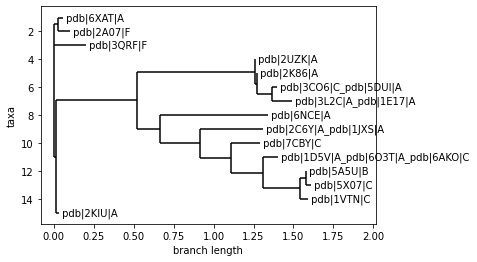

In [35]:
from Bio import Phylo
tree = Phylo.read("T1.raxml.bestTree", "newick")
Phylo.draw(tree)

**QUESTION:** How many clades do you see? How many common ancestors there are? Who are the members of the clade containing our query sequence?

4. Now we need to test the reliability (reproducibility) of our phylogenetic tree using the **boostrapping method** that we discussed during our Lectures. Remember that this is not part of the tree construction method, but a phylogeny test.

  While usually 1000-2000 bootstrap replicates are suggested for determining the confidence of the phylogenetic tree, RAxML also has a so-called **bootstopping** method that determines how many bootstrap replicates are required to obtain stable support values. However, for a speedy tutorial, we have requested 100 boostrap replicates only.

In [36]:
!raxml-ng --bootstrap --msa T1.raxml.rba --model LG+G4 --prefix T2 --threads 2 --bs-tree 100


RAxML-NG v. 0.9.0 released on 20.05.2019 by The Exelixis Lab.
Developed by: Alexey M. Kozlov and Alexandros Stamatakis.
Contributors: Diego Darriba, Tomas Flouri, Benoit Morel, Sarah Lutteropp, Ben Bettisworth.
Latest version: https://github.com/amkozlov/raxml-ng
Questions/problems/suggestions? Please visit: https://groups.google.com/forum/#!forum/raxml

RAxML-NG was called at 27-Sep-2021 00:02:30 as follows:

raxml-ng --bootstrap --msa T1.raxml.rba --model LG+G4 --prefix T2 --threads 2 --bs-tree 100

Analysis options:
  run mode: Bootstrapping
  start tree(s): 
  bootstrap replicates: 100
  random seed: 1632700950
  tip-inner: OFF
  pattern compression: ON
  per-rate scalers: OFF
  site repeats: ON
  branch lengths: proportional (ML estimate, algorithm: NR-FAST)
  SIMD kernels: AVX2
  parallelization: PTHREADS (2 threads), thread pinning: OFF

         since the binary MSA file already contains a model definition.
         If you want to change the model, please re-run RAxML-NG 
    

**QUESTION:** A reliable clade should have bootstrapping values **> 70**. What would a bootstrapping value of 70 mean?

**💡 HINT:** You can still check the convergence of the boostrapping test afterwards by executing the following command:

```
!raxml-ng --bsconverge --bs-trees T2.raxml.bootstraps --prefix Test --threads 2 --bs-cutoff 0.03
```

In practice, a convergence cutoff value of 3% should be sufficient in most cases.


5. Now, we will map the support values obtained from the boostrapping test onto the best-scoring ML tree on the original MSA. Once you ran the cell code below, use the Phylo package again to show the phylogenetic tree with its bootstrapping values.

In [37]:
!raxml-ng --support --tree T1.raxml.bestTree --bs-trees T2.raxml.bootstraps --prefix T3 --threads 2


RAxML-NG v. 0.9.0 released on 20.05.2019 by The Exelixis Lab.
Developed by: Alexey M. Kozlov and Alexandros Stamatakis.
Contributors: Diego Darriba, Tomas Flouri, Benoit Morel, Sarah Lutteropp, Ben Bettisworth.
Latest version: https://github.com/amkozlov/raxml-ng
Questions/problems/suggestions? Please visit: https://groups.google.com/forum/#!forum/raxml

RAxML-NG was called at 27-Sep-2021 00:05:54 as follows:

raxml-ng --support --tree T1.raxml.bestTree --bs-trees T2.raxml.bootstraps --prefix T3 --threads 2

Analysis options:
  run mode: Compute bipartition support (Felsenstein Bootstrap)
  start tree(s): user
  random seed: 1632701154
  SIMD kernels: AVX2
  parallelization: PTHREADS (2 threads), thread pinning: OFF

Reading reference tree from file: T1.raxml.bestTree
Reference tree size: 15

Reading bootstrap trees from file: T2.raxml.bootstraps
Loaded 100 trees with 15 taxa.

Best ML tree with Felsenstein bootstrap (FBP) support values saved to: /content/T3.raxml.support

Execution 

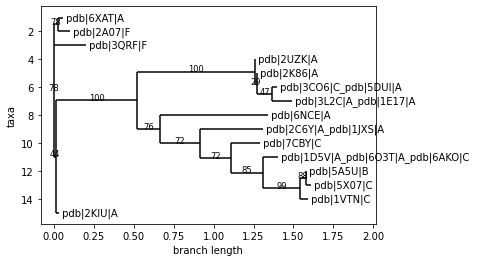

In [41]:
#Here, use the biopython Phylo package again!
#ADD A CODE BELOW TO DRAW THIS TREE WITH BOOTSTRAP VALUES
from Bio import Phylo
tree = Phylo.read("T3.raxml.support", "newick")
Phylo.draw(tree)

6. With this, we are done with inferring our phylogenetic trees. Also, we can get and download the **YourFileName.raxml.bestTree** file (which is the tree file) an see it in the visualizing website [**iTOL**](https://itol.embl.de/). 

  At the top of this site, there is an **UPLOAD** button. We can press the button and upload the besttree file to nicely draw our phylogenetic tree.

7. We will now **use the ML tree** to obtain an estimation of the **ancestral sequence** for the FoxP clade. The DNA encoding these protein sequences are usually synthesized by researchers to evaluate their structure and function and allowing inference of the cellular, environmental and functional contexts of ancestral and extant organisms.

  Since we already have the MSA and the ML tree, we do not need anything extra to obtain the ancestral sequences at each of the internal nodes. Just use the code below.


In [43]:
!raxml-ng --ancestral --msa clear_aligned_trimmed.fasta --tree T1.raxml.bestTree --model LG+G4 --prefix ASR


RAxML-NG v. 0.9.0 released on 20.05.2019 by The Exelixis Lab.
Developed by: Alexey M. Kozlov and Alexandros Stamatakis.
Contributors: Diego Darriba, Tomas Flouri, Benoit Morel, Sarah Lutteropp, Ben Bettisworth.
Latest version: https://github.com/amkozlov/raxml-ng
Questions/problems/suggestions? Please visit: https://groups.google.com/forum/#!forum/raxml

RAxML-NG was called at 27-Sep-2021 00:17:19 as follows:

raxml-ng --ancestral --msa clear_aligned_trimmed.fasta --tree T1.raxml.bestTree --model LG+G4 --prefix ASR

Analysis options:
  run mode: Ancestral state reconstruction
  start tree(s): user
  random seed: 1632701839
  tip-inner: ON
  pattern compression: OFF
  per-rate scalers: OFF
  site repeats: OFF
  branch lengths: proportional (ML estimate, algorithm: NR-FAST)
  SIMD kernels: AVX2
  parallelization: NONE/sequential

[00:00:00] Reading alignment from file: clear_aligned_trimmed.fasta
[00:00:00] Loaded alignment with 15 taxa and 93 sites

Alignment comprises 1 partitions and

8. Now, open the **YourFileName.raxml.ancestralStates** to see the most probable sequences based on the probabilities for each position of the alignment (which are contained in the **YourFileName.raxml.ancestralProbs** file).

  But which sequence correspond to which node? You can now draw the **YourFileName.raxml.ancestralTree** to check the numbers of each node and determine which sequence correspond to the FoxP clade.

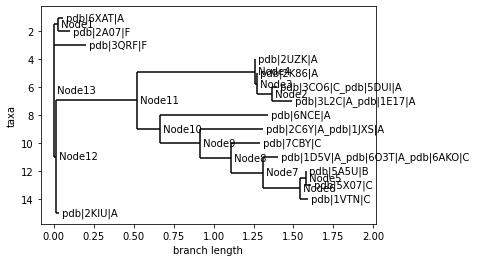

In [44]:
#Here, se the biopython Phylo package again!
from Bio import Phylo
tree = Phylo.read("ASR.raxml.ancestralTree", "newick")
Phylo.draw(tree)

**📚 HOMEWORK:** Now, as a final exercise, please compare the sequence of the ancestral node for the FoxP clade with the sequences shown in the Overview for FoxP and for the FoxP homologs. Also, take a look at the structures of the different Fox homologs that you have in your alignment by searching for the accession codes in the [Protein Data Bank](https://www.rcsb.org). 

  Based on the information provided in the Overview of this tutorial, the phylogenetic analysis of FoxP proteins and their homologs, the reconstructed ancestral sequences for each node and your observations of the different structures that are included in your sequence alignment:

1. Can we say something about the most probable oligomeric state of this protein based on this sequence?

2. Can we say something about how this subfamily gained the ability to dimerize during the evolution of Fox proteins?

3. Is there any element that we did not take into account that could significantly alter the results from our analysis?


**This is the end of the third tutorial. Good science!**